In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import numpy as np
from prediction.functions import new_r2

In [2]:
PREDICTION_MODEL = ['lasso', 'ridge', 'enet', 'random_forest', 'lgb', 'nn3']
FS_METHODS = ['all', 'granger', 'huang', 'IAMB', 'mda', 'mdi', 'MMMB', 'sfi']
EVALUATION_START = '2012-07-03'

## Selected Features

In [3]:
# features = []

# for fs in FS_METHODS:
#     assets = glob('results/feature_selection/' + fs + '/indices/*.csv')
#     for asset_path in assets:
#         df = pd.read_csv(asset_path)

#         r2_eval_df = df.copy()
#         r2_eval_df.set_index('date', inplace=True)
#         r2_eval_df = r2_eval_df.loc[EVALUATION_START:]
#         r2 = new_r2(r2_eval_df['return'].values, r2_eval_df['prediction'].values)
#         r2_df = pd.DataFrame([{'model': model,
#                             'fs': fs,
#                             'r2': r2}])
#         r2s.append(r2_df)

#         melt_df = df.melt('date')
#         melt_df['model'] = model
#         melt_df['fs'] = fs
#         predictions.append(melt_df)

# features_df = pd.concat(features, axis=0)

## Aggregate prediction results

In [4]:
predictions = []
r2s = []

for model in PREDICTION_MODEL:
    for fs in FS_METHODS:
        assets = glob('results/forecast/' + fs + '/indices/' + model + '/*.csv')
        for asset_path in assets:
            df = pd.read_csv(asset_path)
            df.set_index('date', inplace=True)
            df = df.loc[EVALUATION_START:]
            df = df.reset_index()

            r2_eval_df = df.copy()
            r2 = new_r2(r2_eval_df['return'].values, r2_eval_df['prediction'].values)
            r2_df = pd.DataFrame([{'model': model,
                                'fs': fs,
                                'r2': r2}])
            r2s.append(r2_df)

            melt_df = df.melt('date')
            melt_df['model'] = model
            melt_df['fs'] = fs
            predictions.append(melt_df)

predictions_df = pd.concat(predictions, axis=0)
r2_df = pd.concat(r2s, axis=0)

## R2 -  Gu, Kelly, and Xiu (2020)

In [5]:
r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100

r2                                                           
model        enet     lasso       lgb          nn3 random_forest       ridge
fs                                                                          
IAMB    -0.139413  0.260719 -0.017202    -0.978241     -2.250976   -3.198925
MMMB    -0.045446  0.260719 -0.153171    -2.183094     -2.512986   -2.444120
all      0.260719  0.260719  0.074810     0.257907      0.178834 -888.988066
granger  0.260719  0.260719  0.177426    -0.930159      0.147931   -4.880639
huang    0.186985  0.161865  0.204265    -0.140871      0.228042    0.124219
mda      0.260719  0.260719  0.221990    -6.346761      0.314279  -66.791997
mdi      0.260719  0.260719  0.167583 -3804.521634      0.257050 -115.303802
sfi      0.260719  0.260719  0.134550  -238.008490      0.188185 -469.520400

In [6]:
(r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100).sum(axis=1)

fs
IAMB         -6.324039
MMMB         -7.078099
all        -887.955077
granger      -4.964003
huang         0.764505
mda         -72.081051
mdi       -3918.879365
sfi        -706.684716
dtype: float64

In [7]:
(r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100).sum(axis=1)/(r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100).std(axis=1)

fs
IAMB      -4.545295
MMMB      -5.335830
all       -2.446075
granger   -2.435661
huang      5.613025
mda       -2.673048
mdi       -2.537241
sfi       -3.588909
dtype: float64

## OOS portfolio returns

In [121]:
model = 'lgb'

benchmark_buynhold_df = predictions_df.loc[(predictions_df['model'] == model)&(predictions_df['variable'] == 'return')&(predictions_df['fs'] == 'all')]
benchmark_buynhold_df = benchmark_buynhold_df.pivot_table(index=['date'], columns=['variable'], values=['value'])

fs_model_pred_df = predictions_df.loc[(predictions_df['model'] == model)&(predictions_df['variable'] != 'return')]
fs_model_pred_df = fs_model_pred_df.pivot_table(index=['date'], columns=['model', 'fs'], values=['value'])
names = fs_model_pred_df.columns.droplevel()
fs_model_ret_df = pd.DataFrame(np.where(fs_model_pred_df > 0, 1, -1) * benchmark_buynhold_df.values)
fs_model_ret_df.columns = names
fs_model_ret_df.index = benchmark_buynhold.index

all_ret = pd.concat([fs_model_ret_df, benchmark_buynhold_df], axis=1)

<AxesSubplot:xlabel='date'>

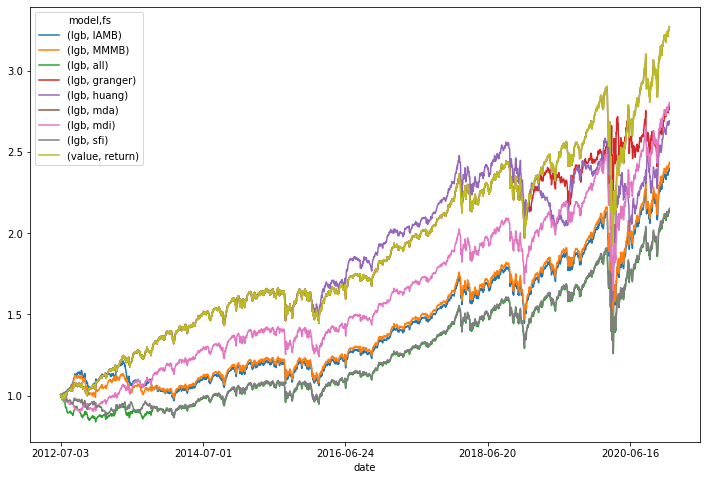

In [122]:
(1 + all_ret).cumprod().plot(figsize=(12, 8))

In [193]:

all_ret = pd.concat([fs_model_ret_df, benchmark_buynhold_df], axis=1)
benchmark_buynhold_df = predictions_df.loc[(predictions_df['model'] == model)&(predictions_df['variable'] == 'return')&(predictions_df['fs'] == 'all')]
benchmark_buynhold_df = benchmark_buynhold_df.pivot_table(index=['date'], columns=['variable'], values=['value'])
melt_benchmark_buynhold_df = benchmark_buynhold.reset_index().melt('date')
melt_benchmark_buynhold_df.rename(columns={melt_benchmark_buynhold_df.columns[1]: 'model',
                                           melt_benchmark_buynhold_df.columns[2]: 'fs'}, inplace=True)

metrics_df = []
positions_df = []
for model in PREDICTION_MODEL:
    fs_model_pred_df = predictions_df.loc[(predictions_df['model'] == model)&(predictions_df['variable'] != 'return')]
    fs_model_pred_df = fs_model_pred_df.pivot_table(index=['date'], columns=['model', 'fs'], values=['value'])
    names = fs_model_pred_df.columns.droplevel()
    fs_model_ret_df = pd.DataFrame(np.where(fs_model_pred_df > 0, 1, -1) * benchmark_buynhold_df.values)
    fs_model_ret_df.columns = names
    fs_model_ret_df.index = benchmark_buynhold.index
    metrics_df.append(fs_model_ret_df.reset_index().melt('date'))

    positons_fs_model_df = pd.DataFrame(np.where(fs_model_pred_df > 0, 1, -1))
    positons_fs_model_df.columns = names
    positons_fs_model_df.index = benchmark_buynhold.index
    positions_df.append(positons_fs_model_df.reset_index().melt('date'))

positions_df = pd.concat(positions_df, axis=0)
pivot_positions_df = positions_df.pivot_table(index=['date'], columns=['model', 'fs'], values=['value'])
metrics_ex_ret_df = pd.concat(metrics_df, axis=0)
metrics_df = pd.concat([metrics_ex_ret_df, melt_benchmark_buynhold_df], axis=0)
pivot_metrics_df = metrics_df.pivot_table(index=['date'], columns=['model', 'fs'], values=['value'])

<ipython-input-193-6f2583ae0ef1>:4: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  melt_benchmark_buynhold_df = benchmark_buynhold.reset_index().melt('date')


## Sharpe ratio

In [180]:
((pivot_metrics_df.mean() / pivot_metrics_df.std()) * np.sqrt(252)).sort_values(ascending=False)

       model          fs     
value  random_forest  mda        1.084539
                      MMMB       1.023807
                      all        0.938122
       lasso          MMMB       0.913600
                      sfi        0.913600
                      mdi        0.913600
                      mda        0.913600
                      granger    0.913600
                      all        0.913600
       value          return     0.913600
       enet           sfi        0.913600
                      mdi        0.913600
                      mda        0.913600
       lgb            mda        0.913600
       enet           granger    0.913600
                      all        0.913600
       lasso          IAMB       0.913600
       nn3            mdi        0.890223
                      all        0.877664
       random_forest  IAMB       0.865958
                      mdi        0.824939
                      sfi        0.815114
       lgb            mdi        0.805462
    

In [181]:
((pivot_metrics_df.mean() / pivot_metrics_df.std()) * np.sqrt(252)).reset_index().pivot_table(index=['fs'], columns=['model'], values=[0])

0                                                        \
model        enet     lasso       lgb       nn3 random_forest     ridge   
fs                                                                        
IAMB     0.794700  0.913600  0.696738 -0.235422      0.865958 -0.197376   
MMMB     0.788964  0.913600  0.707135  0.131237      1.023807 -0.064499   
all      0.913600  0.913600  0.616811  0.877664      0.938122  0.000257   
granger  0.913600  0.913600  0.799185  0.246127      0.629445  0.252197   
huang    0.733691  0.506933  0.777187  0.642495      0.678683  0.393781   
mda      0.913600  0.913600  0.913600  0.522656      1.084539 -0.844195   
mdi      0.913600  0.913600  0.805462  0.890223      0.824939  0.690004   
return        NaN       NaN       NaN       NaN           NaN       NaN   
sfi      0.913600  0.913600  0.620591  0.795312      0.815114  0.094610   

                 
model     value  
fs               
IAMB        NaN  
MMMB        NaN  
all         NaN  
granger     NaN  
huang       NaN  
mda         NaN  
mdi         NaN  
return   0.9136  
sfi         NaN

## Hit rate

In [211]:
discrete_returns = np.where(benchmark_buynhold_df > 0, 1, 0)
discrete_positions = np.where(pivot_positions_df > 0, 1, 0)
mult = pd.DataFrame(discrete_returns * discrete_positions)
mult.columns = pivot_positions_df.columns
buys_hit_rate_per_asset = mult.sum(axis=0)

discrete_returns = np.where(benchmark_buynhold_df <= 0, 1, 0)
discrete_positions = np.where(pivot_positions_df <= 0, 1, 0)
mult = pd.DataFrame(discrete_returns * discrete_positions)
mult.columns = pivot_positions_df.columns
sells_hit_rate_per_asset = mult.sum(axis=0)

hit_rate_per_asset = (buys_hit_rate_per_asset + sells_hit_rate_per_asset) / pivot_positions_df.notnull().count(axis=0)
hit_rate_per_asset.sort_values(ascending=False)

       model          fs     
value  nn3            all        0.562412
       lasso          granger    0.556802
                      IAMB       0.556802
                      sfi        0.556802
                      mdi        0.556802
                      mda        0.556802
                      all        0.556802
                      MMMB       0.556802
       lgb            mda        0.556802
       enet           sfi        0.556802
                      mdi        0.556802
                      mda        0.556802
                      granger    0.556802
                      all        0.556802
       nn3            mdi        0.556335
       random_forest  mda        0.555867
                      all        0.555867
                      sfi        0.555867
       lgb            mdi        0.553997
       enet           MMMB       0.553530
       random_forest  mdi        0.552595
                      MMMB       0.551660
       enet           IAMB       0.551660
    

In [209]:
hit_rate_per_asset.reset_index().pivot_table(index=['fs'], columns=['model'], values=[0])

0                                                      
model        enet     lasso       lgb       nn3 random_forest     ridge
fs                                                                     
IAMB     0.551660  0.556802  0.546050  0.486209      0.544180  0.502571
MMMB     0.553530  0.556802  0.549322  0.519402      0.551660  0.501169
all      0.556802  0.556802  0.547920  0.562412      0.555867  0.505376
granger  0.556802  0.556802  0.544180  0.517999      0.541842  0.504441
huang    0.546517  0.532492  0.548855  0.533427      0.549322  0.531557
mda      0.556802  0.556802  0.556802  0.513791      0.555867  0.477793
mdi      0.556802  0.556802  0.553997  0.556335      0.552595  0.508649
sfi      0.556802  0.556802  0.543712  0.549790      0.555867  0.510986

## Maximum drawdown

In [220]:
cum_prod_df = (1 + pivot_metrics_df).cumprod()
previous_peaks_df =  cum_prod_df.cummax()
drawdown_df = (cum_prod_df - previous_peaks_df)/previous_peaks_df
drawdown_df.min().sort_values(ascending=False)

       model          fs     
value  lgb            granger   -0.193663
       random_forest  all       -0.243396
                      mdi       -0.243989
                      MMMB      -0.255614
                      mda       -0.261297
                      IAMB      -0.272083
                      granger   -0.281978
       nn3            mda       -0.289204
       ridge          mdi       -0.319034
       nn3            all       -0.337904
       lgb            IAMB      -0.337904
       nn3            huang     -0.337904
       enet           MMMB      -0.337904
       lgb            mda       -0.337904
       value          return    -0.337904
       lasso          mdi       -0.337904
                      mda       -0.337904
                      granger   -0.337904
                      all       -0.337904
                      MMMB      -0.337904
                      IAMB      -0.337904
       enet           sfi       -0.337904
                      mdi       -0.337904
    

In [223]:
drawdown_df.min().reset_index().pivot_table(index=['fs'], columns=['model'], values=[0])

0                                                        \
model        enet     lasso       lgb       nn3 random_forest     ridge   
fs                                                                        
IAMB    -0.337904 -0.337904 -0.337904 -0.636589     -0.272083 -0.467250   
MMMB    -0.337904 -0.337904 -0.337904 -0.443924     -0.255614 -0.400009   
all     -0.337904 -0.337904 -0.337904 -0.337904     -0.243396 -0.493549   
granger -0.337904 -0.337904 -0.193663 -0.337904     -0.281978 -0.435665   
huang   -0.337904 -0.357716 -0.390384 -0.337904     -0.337904 -0.428313   
mda     -0.337904 -0.337904 -0.337904 -0.289204     -0.261297 -0.751965   
mdi     -0.337904 -0.337904 -0.337904 -0.337904     -0.243989 -0.319034   
return        NaN       NaN       NaN       NaN           NaN       NaN   
sfi     -0.337904 -0.337904 -0.337904 -0.337904     -0.375342 -0.573527   

                   
model       value  
fs                 
IAMB          NaN  
MMMB          NaN  
all           NaN  
granger       NaN  
huang         NaN  
mda           NaN  
mdi           NaN  
return  -0.337904  
sfi           NaN

## Probability of Backtest Overfitting (PBO) Bailey et al. (2013)